### The goal of this project is to apply reinforcement learning methods to a simple card game (It's more like Blackjack).

### The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
### Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a color of red (probability 1/3) or black (probability 2/3).
### There are no aces or picture (face) cards in this game.
### At the start of the game, both the player and the dealer draw one black card (fully observed).
### Each turn the player may either stick or hit.
### If the player hits, then she draws another card from the deck.
### If the player sticks, she receives no further cards.
### The values of the player’s cards are added (black cards) or subtracted (red cards)
### If the player’s sum exceeds 21 or becomes less than 1, then she “goes bust” and loses the game (reward -1)
### If the player sticks, then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Importing required libraries

In [1]:
import numpy as np
import random
from enum import Enum
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

### First run below code to initialize the function of plotting
### plot_value_function: This function plots the value function of an agent as a surface plot.

### plot_error_vs_episode: This function plots the square root error versus episode number for multiple lambda values. It uses matplotlib to create the plot.

### plot_error_vs_lambda: This function plots the square root error versus lambda for a trained model. It also uses matplotlib to create the plot.

In [2]:
def plot_value_function(agent, title='Value Function', generate_gif=False, train_steps=None):
    fig = plt.figure(title, figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    
     # Get the value function from the agent
    V = agent.get_value_function()
    
    if generate_gif:
        print('GIF saved as %s' % title)
        
        
    # Function to plot each frame of the animation
    def plot_frame(ax):
        min_x, max_x = 1, V.shape[0]
        min_y, max_y = 1, V.shape[1]
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)
        X, Y = np.meshgrid(x_range, y_range)

        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)
        
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)
    
     # Function to animate the plot
    def animate(frame):
        ax.clear()
        surf = plot_frame(ax)
        if generate_gif:
            i = agent.iterations
            step_size = int(min(max(1, agent.iterations), 2 ** 16)) if train_steps is None else train_steps
            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)
        fig.canvas.draw()
        return surf
    
    # Create the animation
    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # Save the animation as a GIF or show the plot
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()

def plot_error_vs_episode(sqrt_error, parameter_values, train_steps=1000000, eval_steps=1000,
                          title='SQRT error VS episode number', save_as_file=False):
    assert eval_steps != 0
    x_range = np.arange(0, train_steps, eval_steps)
    assert len(sqrt_error) == len(parameter_values)
    for e in sqrt_error:
        assert len(list(x_range)) == len(e)
    
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    # Plot sqrt_error for each parameter value
    for i in range(len(sqrt_error)-1, -1, -1):
        ax.plot(x_range, sqrt_error[i], label='lambda %.2f' % parameter_values[i])
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

def plot_error_vs_lambda(sqrt_error, parameter_values, title='SQRT error vs lambda', save_as_file=False):
    assert len(sqrt_error) == len(parameter_values)
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    
    # Plot sqrt_error versus lambda
    y = [s[-1] for s in sqrt_error]
    ax.plot(parameter_values, y,label='SQRT error')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()


## Implementation of Environment

### Below is the code where cards are drawn from a deck and players (including a dealer) take actions based on the game state. The Deck class manages the deck of cards, the State class represents the state of the game, and the Player and Dealer classes define the behavior of players in the game.

In [3]:
class Color:
    RED = "Red"
    BLACK = "Black"

class Card:
    def __init__(self, color=None):
        self.value = random.randint(1, 10)
        self.color = color if color in [Color.RED, Color.BLACK] else self._get_random_color()

    def _get_random_color(self):
        random_number = random.random()
        if random_number <= 1/3.0:   # color of red (probability 1/3) or black (probability 2/3)
            return Color.RED
        else:
            return Color.BLACK

class Deck(object):
    def take_card(self, color=None):
        return Card(color)

class State(object):
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal

class Action(Enum):
    STICK = 0
    HIT = 1

class Player(object):
    def policy(self, s):
        raise NotImplementedError()

class Dealer(Player):  #  #The dealer always sticks on any sum of 17 or greater, and hits otherwise
    def policy(self, s):
        return Action.STICK if s.dealer_sum >= 17 else Action.HIT  

### Basically, below code include the logic of a simple card game environment, where the agent (player) interacts with the dealer by taking actions (hit or stick) and receiving rewards based on the outcome of each step.

In [4]:
class Environment(object):
    def __init__(self):
        # Initialize the environment with a dealer and a deck
        self.dealer = Dealer() # Create a dealer
        self.deck = Deck()  # Create a deck of cards
        self.agent_max_value = 21 # Maximum value of the agent's hand
        self.dealer_max_value = 10 # Maximum value of the dealer's hand 
        self.actions_count = 2  # Number of possible actions (HIT, STICK)

    def check_bust(self, player_sum):
         # Check if the player has busted (sum of cards > 21)
        return not 1 <= player_sum <= 21

    def generate_reward_bust(self, s):
         # Generate reward based on the state of the game
        if s.agent_sum > s.dealer_sum:
            return 1 # Agent wins
        elif s.agent_sum == s.dealer_sum:
            return 0 # Draw
        else:
            return -1 # Agent loses

    def take_card(self, card_color=None):
         # Take a card from the deck (black or red)
        Card = self.deck.take_card(card_color)
        return Card.value if Card.color == Color.BLACK else -Card.value

    def dealer_turn(self, s):
        # Simulate the dealer's turn until they stick or bust
        action = None
        while not s.is_terminal and action != Action.STICK:
            action = self.dealer.policy(s) # Get dealer's action
            if action == Action.HIT:
                s.dealer_sum += self.take_card() # Deal a card to the dealer
            s.is_terminal = self.check_bust(s.dealer_sum) # Check if dealer has busted
        return s

    def initial_state(self):
        # Initialize the initial state of the game with two cards (black)
        return State(self.take_card(Color.BLACK), self.take_card(Color.BLACK))

    def step(self, s, a):
        # Take a step in the game based on the agent's action
        r = 0 # Initialize reward
        next_s = copy.copy(s)  # Create a copy of the current state
        if a == Action.STICK: 
            
            # If agent decides to stick, simulate dealer's turn
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1 # If dealer busted, agent wins
            else:
                next_s.is_terminal = True
                r = self.generate_reward_bust(next_s)  # Generate reward based on outcome
        else:
            # If agent decides to hit, deal a card to the agent
            next_s.agent_sum += self.take_card()
            next_s.is_terminal = self.check_bust(next_s.agent_sum)
            if next_s.is_terminal:
                r = -1  # If agent busted, agent loses
        return next_s, r  # Return the next state and the reward

### Creating the instance of environment

In [5]:
environment = Environment()

### This Agent class provides basic functionality for an agent , including initialization, utility functions for action selection and value function calculation, and a method for training the agent. 

### We are creating general agent class because it provides common functionalities and attributes shared among different types of agents. Which includes methods like policy, train, and attributes like iterations and wins. By defining these once in the Agent class, subclasses can inherit these functionalities without repeating the code

In [6]:
class Agent(Player):
    def __init__(self, environment, No=100, discount_factor=1):
        self.env = environment
        self.No = No
        self.disc_factor = discount_factor
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])
        self.wins = 0.0
        self.iterations = 0.0

    def get_clear_tensor(self):
        return np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1,
                         self.env.actions_count))

    def choose_random_action(self): #Choose a random action based on a predefined probability.
        return Action.HIT if random.random() <= 0.5 else Action.STICK
    
    def choose_best_action(self, s): #Choose the best action based on the current state.
        raise NotImplemented()
    
    def get_max_action(self, s): #Get the maximum action value for a given state.
        return 0.0
    
    def get_value_function(self): #Calculate the value function for all states.
        for i in range(1, self.env.dealer_max_value + 1):
            for j in range(1, self.env.agent_max_value + 1):
                s = State(i, j)
                self.V[i][j] = self.get_max_action(s)
        return self.V

    def train(self, steps): #Train the agent for a specified number of steps.
        for e in range(steps):
            pass
        return self.get_value_function()


## 2) Monte-Carlo Control Implementation

### The MCAgentEvaluation class implements Monte Carlo evaluation to estimate the value function of the environment. It uses a simple policy for action selection during evaluation and updates the value function based on the observed returns from sampled episodes.

In [9]:
class MCAgentEvaluation(Agent):
    def __init__(self, environment, No=100, discount_factor=1): ## Initialize the agent with the specified environment, number of episodes, and discount factor
        super().__init__(environment, No, discount_factor) ## Initialize the number of visits to state-action pairs
        self.N = self.get_clear_tensor() 
        self.G_s = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1]) # Initialize the cumulative returns for each state-action pair

    def get_value_function(self):
        return self.V

    def predict(self, episode): # Update the value function based on a given episode
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            # Calculate the return for the current time step
            Gt = sum([x[2] * (self.disc_factor ** i) for i, x in enumerate(episode[j:])])
            self.G_s[d_sum][a_sum] += Gt
             # Calculate the average return for the state-action pair and update the value function
            self.V[d_sum][a_sum] = self.G_s[d_sum][a_sum] / sum(self.N[s.dealer_sum, s.agent_sum, :])

    def policy(self, s):
        # Define the agent's policy based on the current state
        if s.agent_sum >= 17:
            action = Action.STICK
        else:
            action = Action.HIT
            # Increment the visit count for the chosen action in the current state
        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action

    def train(self, steps):
        # Train the agent for a specified number of steps
        for e in range(steps):
            episode = []
            s = self.env.initial_state()
            # Generate an episode until termination
            while not s.is_terminal:
                a = self.policy(s)
                 # Take the chosen action and observe the next state and reward
                next_s, r = self.env.step(copy.copy(s), a)
                # Append the state-action-reward tuple to the episode
                episode.append((s, a, r))
                 # Transition to the next state
                s = next_s
            self.iterations += 1
            if e % 10000 == 0 and e != 0:
                print("Episode: %d" % e)
                # Update the value function based on the generated episode
            self.predict(episode)
        return self.get_value_function()

MovieWriter imagemagick unavailable; using Pillow instead.


GIF saved as Value function: MC policy evaluation


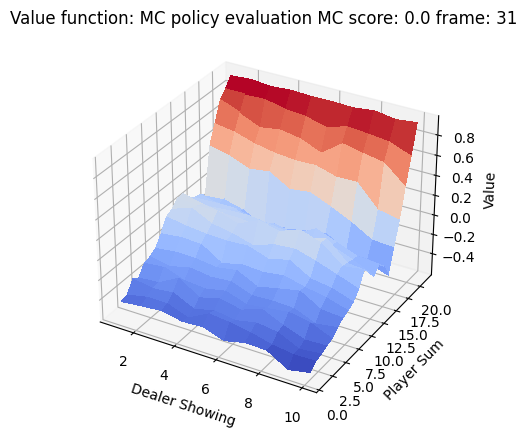

In [8]:
agent_eval = MCAgentEvaluation(environment)
plot_value_function(agent_eval, title='Value function: MC policy evaluation',
                    generate_gif=True, train_steps=1000)

### Below class implements Monte Carlo control to learn the optimal policy for the given environment. It updates the action-value function based on the observed returns from sampled episodes and uses an epsilon-greedy policy for action selection during training.

In [10]:
class MCAgentControl(Agent):
    def __init__(self, environment, No=100, discount_factor=1):
        super().__init__(environment, No, discount_factor)
         # Initialize Q and N tensors
        self.Q = self.get_clear_tensor()
        self.N = self.get_clear_tensor()

    def get_alpha(self, s, a):
        # Calculate the learning rate alpha
        return 1.0 / (self.N[s.dealer_sum][s.agent_sum][a.value])

    def get_e(self, s):
        # Calculate the exploration rate epsilon
        return self.No / ((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))

    def get_max_action(self, s):
        # Get the maximum action value for a given state
        return np.max(self.Q[s.dealer_sum][s.agent_sum])

    def choose_best_action(self, s):
        # Choose the best action based on the Q-values
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def control(self, episode):
        # Perform control using Monte Carlo updates
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            # Calculate the return Gt for each state-action pair
            Gt = sum([x[2] * (self.disc_factor ** i) for i, x in enumerate(episode[j:])])
            # Increment the count of visits to the state-action pair
            self.N[d_sum][a_sum][a.value] += 1
            # Calculate the error between the return and current Q-value
            error = Gt - self.Q[d_sum][a_sum][a.value]
            # Update the Q-value using the learning rate and error
            self.Q[d_sum][a_sum][a.value] += self.get_alpha(s, a) * error
            j += 1

    def policy(self, s):
        # Choose an action based on epsilon-greedy policy
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)
        return action

    def train(self, steps):
        # Train the agent using Monte Carlo Control
        for e in range(steps):
            episode = []
            s = self.env.initial_state()
            while not s.is_terminal:
                a = self.policy(s)
                next_s, r = self.env.step(copy.copy(s), a)
                episode.append((s, a, r))
                s = next_s
                 # Update the number of iterations and wins
            self.iterations += 1
            if e % 10000 == 0 and self.iterations > 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins) / (self.iterations) * 100.0)))
            if r == 1:
                self.wins += 1
            self.control(episode)
        return self.get_value_function()

MovieWriter imagemagick unavailable; using Pillow instead.


GIF saved as MC Control Value function with N0=100
Episode: 0, score: 0.000000
Episode: 0, score: 0.000000
Episode: 0, score: 33.333333
Episode: 0, score: 60.000000
Episode: 0, score: 44.444444
Episode: 0, score: 29.411765
Episode: 0, score: 39.393939
Episode: 0, score: 44.615385
Episode: 0, score: 39.534884
Episode: 0, score: 43.190661
Episode: 0, score: 45.614035
Episode: 0, score: 43.414634
Episode: 0, score: 44.704734
Episode: 0, score: 46.155724
Episode: 0, score: 46.796045
Episode: 0, score: 47.415319
Episode: 10000, score: 48.607163
Episode: 0, score: 49.122646
Episode: 10000, score: 49.610699
Episode: 20000, score: 49.834183
Episode: 30000, score: 50.066115
Episode: 0, score: 50.156400
Episode: 10000, score: 50.310444
Episode: 20000, score: 50.502122
Episode: 30000, score: 50.633786
Episode: 40000, score: 50.701650
Episode: 50000, score: 50.746514
Episode: 60000, score: 50.841585
Episode: 0, score: 50.910561
Episode: 10000, score: 50.995584
Episode: 20000, score: 51.066703
Epis

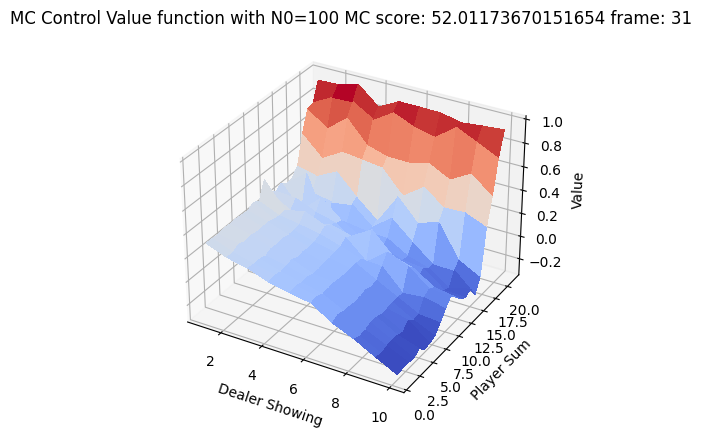

In [11]:
mc_agent = MCAgentControl(environment)
plot_value_function(mc_agent, title='MC Control Value function with N0=100',
                     generate_gif=True)

## 3) TD Learning Implementation

### Below class implements the SARSA algorithm for learning the optimal policy in the given environment which we have created. It updates the action-value function based on observed transitions and uses an epsilon-greedy policy for action selection during training.

In [61]:
class SarsaAgent(Agent):
    def __init__(self, environment, No=100, discount_factor=1, _lambda=1): # Initialize SarsaAgent with given parameters
        super().__init__(environment, No, discount_factor)
        self._lambda = _lambda
        # Initialize eligibility trace, Q-values, and visit counts
        self.E = self.get_clear_tensor()
        self.Q = self.get_clear_tensor()
        self.N = self.get_clear_tensor()

    def get_q(self, s, a):
        # Get Q-value for a given state-action pair
        return self.Q[s.dealer_sum][s.agent_sum][a.value]

    def get_alpha(self, s, a):
        # Calculate the learning rate alpha
        return 1.0 / (self.N[s.dealer_sum][s.agent_sum][a.value])

    def get_e(self, s):
        # Calculate the exploration rate epsilon
        return self.No / ((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))

    def get_max_action(self, s):
        # Get the maximum action value for a given state
        return np.max(self.Q[s.dealer_sum][s.agent_sum])

    def choose_best_action(self, s):
         # Choose the best action based on the Q-values
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def policy(self, s):
         # Choose an action based on epsilon-greedy policy
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)
        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action

    def train(self, steps):
        # Train the agent using Sarsa algorithm
        for e in range(steps):
            self.E = self.get_clear_tensor()
            s = self.env.initial_state()
            a = self.policy(s)
            next_a = a
            while not s.is_terminal:
                # Take action, observe next state and reward
                next_s, r = self.env.step(copy.copy(s), a)
                q = self.get_q(s, a)
                if not next_s.is_terminal:
                    # Choose next action using policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + (q_next - q) * self._lambda
                else:
                    delta = r - q * self._lambda
                self.E[s.dealer_sum][s.agent_sum][a.value] += 1
                alpha = self.get_alpha(s, a)
                # Update Q-values using TD error and eligibility trace
                update_q = alpha * delta * self.E
                self.Q += update_q
                self.E *= (self.disc_factor * self._lambda)
                s = next_s
                a = next_a
                 # Output progress every 100,000 episodes
            if e % 100000 == 0 and e != 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins) / self.iterations) * 100))
                # Increment episode count and wins if agent wins the episode
            self.iterations += 1
            if r == 1:
                self.wins += 1
        return self.get_value_function()

Episode: 100000, score: 50.337000
Episode: 200000, score: 50.926000
Episode: 300000, score: 51.274333
Episode: 400000, score: 51.440500
Episode: 500000, score: 51.547800
Episode: 600000, score: 51.642667
Episode: 700000, score: 51.720000
Episode: 800000, score: 51.793000
Episode: 900000, score: 51.880444


MovieWriter imagemagick unavailable; using Pillow instead.


GIF saved as Sarsa agent plot


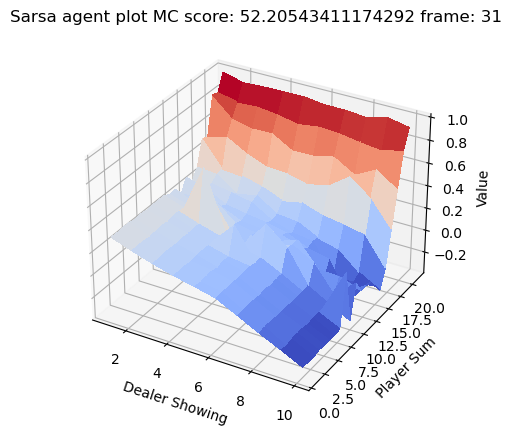

In [62]:
sarsa_agent = SarsaAgent(environment)
sarsa_agent.train(1000000)

plot_value_function(sarsa_agent, title="Sarsa agent plot",
                     generate_gif=True)

### Run the algorithm with parameter values λ ∈ {0, 0.1, 0.2, ..., 1}. Stop each run after 1000 episodes and report the mean-squared error over all states s and actions a, comparing the true values Q∗(s, a) computed in the previous section with the estimated values Q(s, a) computed by Sarsa. Plot the mean- squared error against λ. For λ = 0 and λ = 1 only, plot the learning curve of mean-squared error against episode number

In [63]:
parameter_values = [e/10.0 for e in range(0, 11, 1)]
parameter_values

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [64]:
def calculate_mean_squared_error(q1, q2):
    return np.sum(np.square(q1 - q2))

total_train_steps = 10000
evaluation_steps = 1000
errors = []
for i, lambda_value in enumerate(parameter_values):
    print('Training Sarsa(%.1f)' % lambda_value)
    errors.append([])
    sarsa_agent = SarsaAgent(environment, _lambda=lambda_value)
    for j in range(total_train_steps // evaluation_steps):
        sarsa_agent.train(evaluation_steps)
        errors[i].append(calculate_mean_squared_error(mc_agent.Q, sarsa_agent.Q))


Training Sarsa(0.0)
Training Sarsa(0.1)
Training Sarsa(0.2)
Training Sarsa(0.3)
Training Sarsa(0.4)
Training Sarsa(0.5)
Training Sarsa(0.6)
Training Sarsa(0.7)
Training Sarsa(0.8)
Training Sarsa(0.9)
Training Sarsa(1.0)


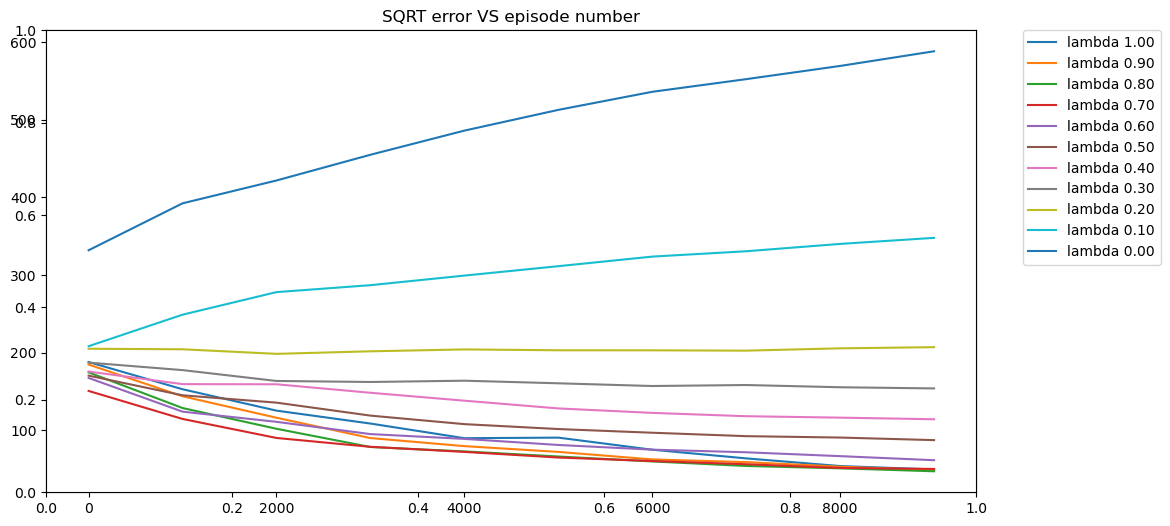

In [65]:
plot_error_vs_episode(errors, parameter_values, train_steps=total_train_steps, eval_steps=evaluation_steps)

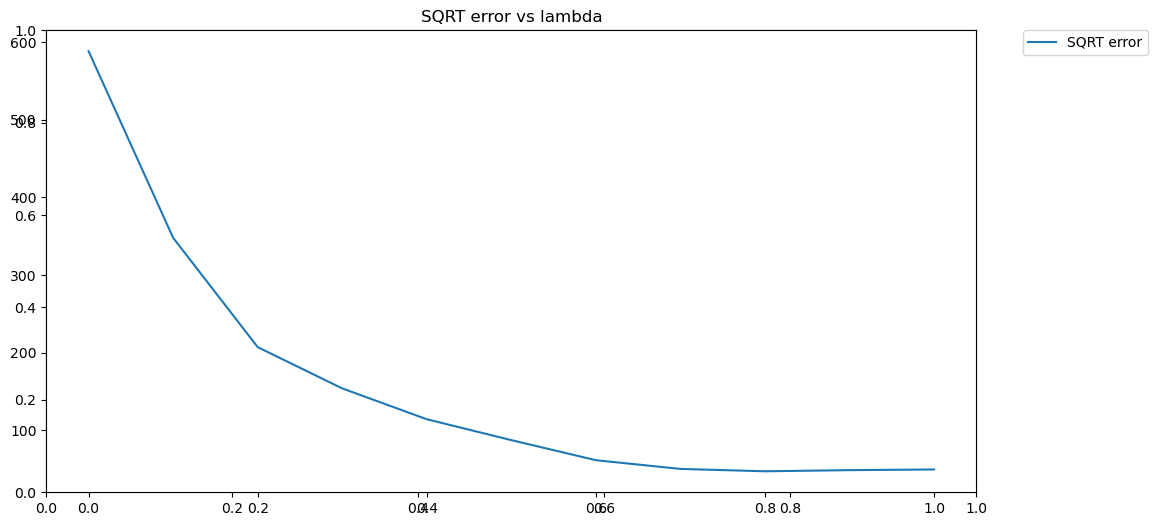

In [66]:
plot_error_vs_lambda(errors, parameter_values)

## References

https://gymnasium.farama.org/v0.27.0/tutorials/blackjack_tutorial/

https://www.analyticsvidhya.com/blog/2018/11/reinforcement-learning-introduction-monte-carlo-learning-openai-gym/#:~:text=Q3.,from%20different%20trajectories%20or%20episodes.

https://medium.com/the-power-of-ai/blackjack-with-reinforcement-learning-95f588dd670c

http://outlace.com/rlpart2.html